In [67]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.fftpack import fftfreq, fft, ifft
from uncertainties import ufloat
from uncertainties import unumpy as unp
from sklearn.metrics import r2_score 

def get_dat_paths():
    current_dir = os.getcwd()
    root_dir_relative = ''
    root_dir = os.path.abspath(os.path.join(current_dir, root_dir_relative))

    dat_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.dat'):
                dat_paths.append(os.path.join(dirpath, filename))
    return dat_paths

dat_paths = get_dat_paths()

In [68]:
def get_data_from_path(path):
    # 读取文件内容
    with open(path, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    distance = path.split('/')[-1]
    distance = float(distance.removesuffix('mm.dat').replace('-','.')) / 10.

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

        # 读取数据表格
    data_start = False
    # data = []
    times, hfs, amps = [], [], []

    for line in lines:
        if line.startswith("Depth ["):
            data_start = True
            continue
        if data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))

    times = np.array(times)
    hfs = np.array(hfs)
    amps= np.array(amps)

    return times, hfs, amps, distance



(0.0, 5.0)

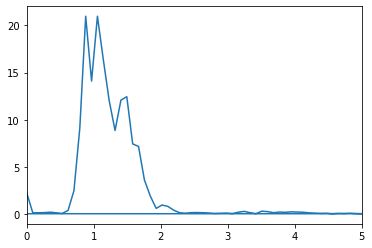

In [69]:
path = dat_paths[3]
times, hfs, amps, distance = get_data_from_path(path)

mask = np.where((times > 20)*(amps > 0.02))

echo_time = times[mask][0]

amplitude = max(amps[mask])

N = len(times[mask])
dt = np.average(np.diff(times[mask]))

xf = fftfreq(N,dt)
yf = fft(hfs[mask])

plt.plot(xf,np.abs(yf))
plt.xlim(0,5)

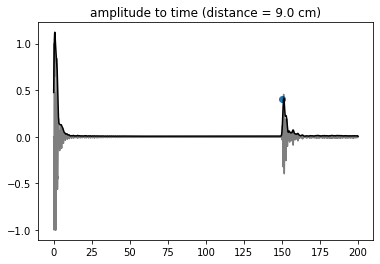

In [70]:
plt.plot(times,amps, color = 'black')
plt.plot(times,hfs, alpha=0.5, color = 'black')
plt.title(f'amplitude to time (distance = {distance:.1f} cm)')
plt.scatter([echo_time],[amplitude])

In [71]:
echo_times = []
amplitudes = []
distances = []

for path in dat_paths:
    times, hfs, amps, distance = get_data_from_path(path)
    mask = np.where((times > 20)*(amps > 0.02))

    echo_time = times[mask][0]
    amplitude = max(amps[mask])

    distances.append(distance)
    
    echo_times.append(echo_time)
    amplitudes.append(amplitude)

echo_times = np.array(echo_times)
amplitudes = np.array(amplitudes)
distances = np.array(distances)

1481.6+/-1.5 m/s


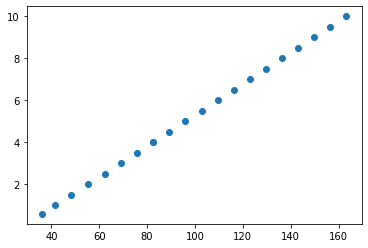

In [72]:
plt.scatter(echo_times, distances)
slope, intercept, r_value, p_value, std_err = linregress(echo_times, distances)
print(speed := 2* ufloat(slope,std_err) * 1e-2/1e-6, 'm/s')
delta_distance = - intercept

distances += delta_distance

(0.0, 12.574517220267216)

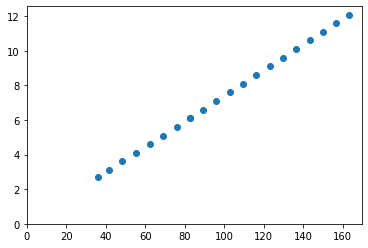

In [73]:
plt.scatter(echo_times, distances)
plt.xlim(0)
plt.ylim(0)

-0.07877190927920029+/-0.003062351476570356

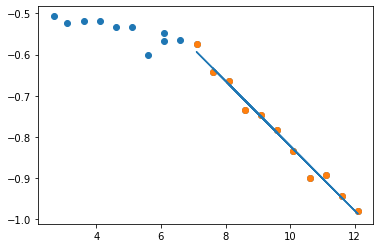

In [74]:

plt.scatter(distances,np.log(amplitudes))

mask = np.where(distances > 7)

plt.scatter(xs := distances[mask],ys := np.log(amplitudes[mask]))
slope, intercept, r_value, p_value, std_err = linregress(xs,ys)
plt.plot(xs, slope * xs + intercept)
ufloat(slope, std_err)

\begin{equation}
I=I_0 e^{-\alpha x}
\end{equation}

\begin{equation}
\ln\left(\frac{A}{1V}\right)=-\frac{\alpha}{2} x + \ln\left(\frac{A_0}{1V}\right)
\end{equation}


In [75]:
def value_compare(exp_value, th_value_text, unit = '', latex = False):
    th_value = float(th_value_text)
    error = ((exp_value - th_value)/th_value ).n * 100
    if latex:
        exp_value_text = str(exp_value).replace('+/-', '(') + ')'
    else:
        exp_value_text = str(exp_value)
    # th_value_text = str(format(th_val e,'e')).replace('+/-', '\pm')
    output = '\SI{'+ exp_value_text + '}{' + unit + '}，與理論值\SI{' + th_value_text + '}{' + unit + '}誤差為\SI{' + f'{error: .1f}' + '}{\percent}'
    if latex:
        print(output)
    else:
        print(output.replace('\SI','').replace('{','').replace('}','').replace('\percent','%'))

In [76]:
alpha = -ufloat(slope,std_err)*2/8.686
value_compare(alpha, '0.02', 'dB/cm')

0.0181+/-0.0007dB/cm，與理論值0.02dB/cm誤差為-9.3%


当声波在液体中传播时，由于吸收(能量转换)、反射、散射或声场的几何形状而衰减。对于整个衰减:

对于许多液体，反射和散射可以忽略不计。声场几何形状的影响可以通过在水中进行比较测量来估计，在水中，低频吸收可以忽略不计。对于声波强度的减弱，适用以下一般衰减定律: